In [11]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

In [12]:
stocks = '^GSPC'  #MSFT 
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2023, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')
s_p500.head(10)

# stocks = pd.read_csv('E:/docs/ICRAT/Innova/Safaricom Price.csv')

# stocks.head(10)


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,1462.420044,4202600000
2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,1459.369995,3829730000
2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,1466.469971,3424290000
2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,1461.890015,3304970000
2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,1457.150024,3601600000
2013-01-09,1457.150024,1464.729980,1457.150024,1461.020020,1461.020020,3674390000
2013-01-10,1461.020020,1472.300049,1461.020020,1472.119995,1472.119995,4081840000
2013-01-11,1472.119995,1472.750000,1467.579956,1472.050049,1472.050049,3340650000
2013-01-14,1472.050049,1472.050049,1465.689941,1470.680054,1470.680054,3003010000


In [13]:
ret = 100 * (s_p500.pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()

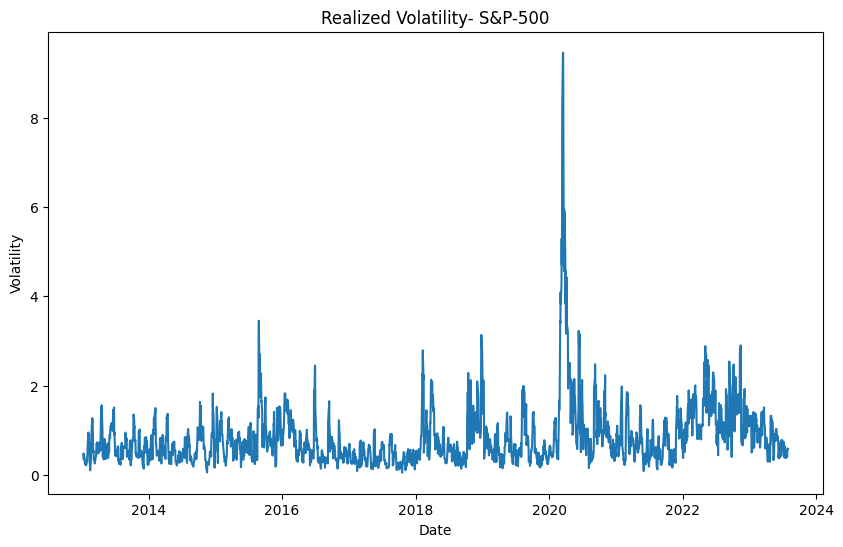

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- S&P-500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

# Calculating the returns of the S&P 500 based on adjusted closing prices.

# Figure 4-1 shows the realized volatility of S&P 500 over the period of 2010–2021. The most striking observation is the spikes around the COVID-19 pandemic.

How to plot clustering and what it looks like

In [15]:
retv = ret.values

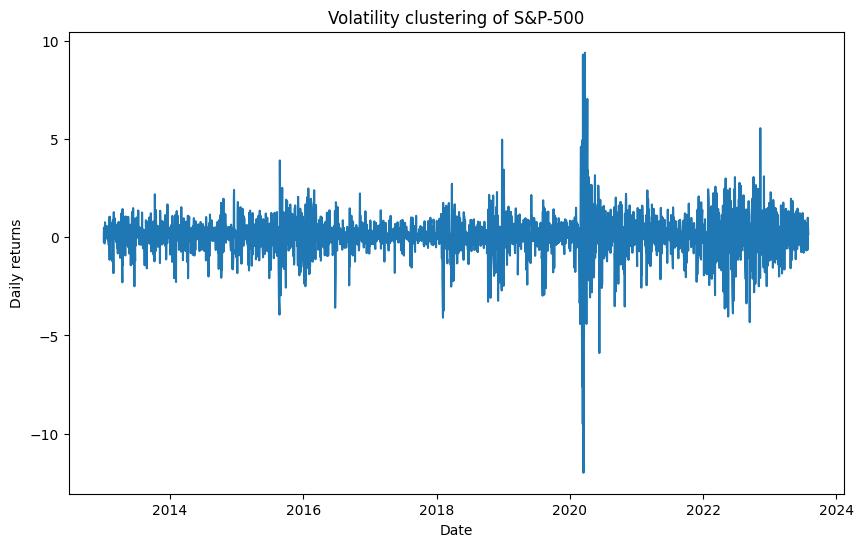

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(s_p500.index[1:], ret)
plt.title('Volatility clustering of S&P-500')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.show()

Similar to spikes in realized volatility, Figure above suggests some large movements, and, these ups and downs happen
 around important events such as the COVID-19 pandemic in mid-2020.

Employ the ARCH model to predict volatility

In [17]:
n = 252
split_date = ret.iloc[-n:].index #Defining the split location and assigning the split data to split variable

In [18]:
sgm2 = ret.var() #Calculating variance of the S&P 500
K = ret.kurtosis() #Calculating kurtosis of the S&P 500
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 *
                                (3.0 * sgm2 - K) * K)) / (6 * K) #Identifying the initial value for slope coefficient a
omega = (1 - alpha) * sgm2 #Identifying the initial value for constant term 'w'
initial_parameters = [alpha, omega]
omega, alpha

(0.6398753897740195, 0.46723321415775376)

In [19]:
@jit(nopython=True, parallel=True) 
def arch_likelihood(initial_parameters, retv):
    omega = abs(initial_parameters[0]) #Taking absolute values and assigning the initial values into related variables
    alpha = abs(initial_parameters[1]) 
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv) #Identifying the initial values of volatility
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 #Iterating the variance of S&P 500 
    logliks = np.sum(0.5 * (np.log(sigma2)+retv ** 2 / sigma2)) #Calculating the log-likelihood
    return logliks

In [20]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

1247.5498857652242

In [21]:
def opt_params(x0, retv):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args = (retv),
                            method='Nelder-Mead',
                            options={'maxiter': 5000}) #Minimizing the log-likelihood function
    params = opt_result.x  #Creating a variable params for optimized parameters
    print('\nResults of Nelder-Mead minimization\n{}\n{}'
        .format(''.join(['-'] * 28), opt_result))
    print('\nResulting params = {}'.format(params))
    return params

In [22]:
params = opt_params(initial_parameters, retv)



Results of Nelder-Mead minimization
----------------------------
 final_simplex: (array([[0.62082063, 0.49732304],
       [0.62073404, 0.49737615],
       [0.6207389 , 0.49724145]]), array([1221.16888319, 1221.16888345, 1221.16888725]))
           fun: 1221.1688831907104
       message: 'Optimization terminated successfully.'
          nfev: 50
           nit: 26
        status: 0
       success: True
             x: array([0.62082063, 0.49732304])

Resulting params = [0.62082063 0.49732304]


In [23]:
def arch_apply(ret):
    omega = params[0]
    alpha = params[1]
    T = len(ret)
    sigma2_arch = np.zeros(T + 1)
    sigma2_arch[0] = np.var(ret)
    for t in range(1, T):
        sigma2_arch[t] = omega + alpha * ret[t - 1] ** 2
    return sigma2_arch

In [24]:
sigma2_arch = arch_apply(ret)

sigma2_arch

array([1.20059084, 0.64245319, 0.73853282, ..., 0.82609734, 1.10606756,
       0.        ])

In [25]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3666.24
Distribution:                  Normal   AIC:                           7336.47
Method:            Maximum Likelihood   BIC:                           7348.24
                                        No. Observations:                 2661
Date:                Wed, Feb 28 2024   Df Residuals:                     2661
Time:                        10:43:50   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6205  3.908e-02     15.878  9.014e-57 [  0.544,  0.69

In [26]:
bic_arch = []

for p in range(1, 5):  #Iterating ARCH parameter p over specified interval
    arch = arch_model(ret, mean='zero', vol='ARCH', p=p).fit(disp='off') #Running ARCH model with different p values
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch): #Finding the minimum BIC score to select the best model
        best_param = p

arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param).fit(disp='off') #Running ARCH model with the best p value
print(arch.summary())
forecast = arch.forecast(start=split_date[0]) #Forecasting the volatility based on the optimized ARCH model
forecast_arch = forecast

print("Zero Mean - ARCH Model Results")


                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3382.69
Distribution:                  Normal   AIC:                           6775.37
Method:            Maximum Likelihood   BIC:                           6804.80
                                        No. Observations:                 2661
Date:                Wed, Feb 28 2024   Df Residuals:                     2661
Time:                        10:43:50   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2543  2.626e-02      9.681  3.646e-22   [  0.20

In [27]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100,
                        np.sqrt(forecast_arch\
                        .variance.iloc[-len(split_date):]
                        / 100))) #Calculating the root mean square error (RMSE) score
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))


The RMSE value of ARCH model is 0.1060


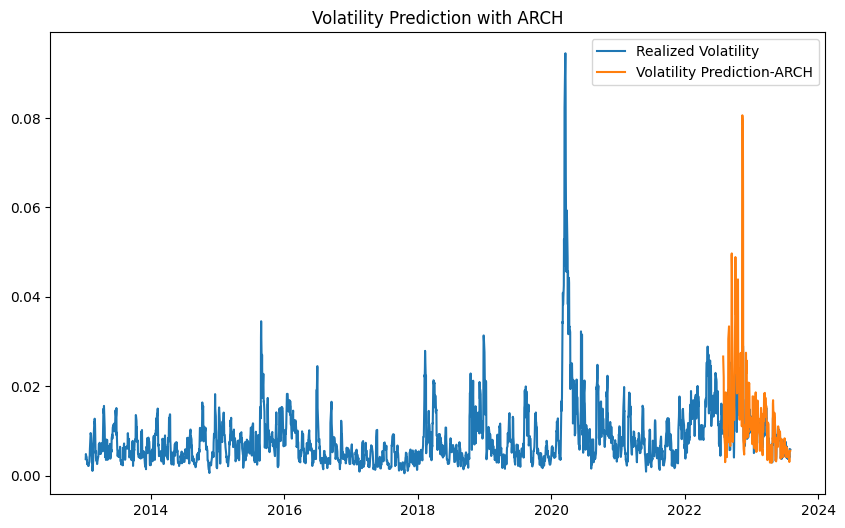

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100,
        label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

In [29]:
#Garch Model
a0 = 0.0001
sgm2 = ret.var()
K = ret.kurtosis()
h = 1 - alpha / sgm2
alpha = np.sqrt(K * (1 - h ** 2) / (2.0 * (K + 3)))
beta = np.abs(h - omega)
omega = (1 - omega) * sgm2
initial_parameters = np.array([omega, alpha, beta])
print('Initial parameters for omega, alpha, and beta are \n{}\n{}\n{}'
    .format(omega, alpha, beta))

Initial parameters for omega, alpha, and beta are 
0.4325248522602131
0.5118987816766206
0.028898536661228214


In [30]:
retv = ret.values

In [31]:
@jit(nopython=True, parallel=True)
def garch_likelihood(initial_parameters, retv):
    omega = initial_parameters[0]
    alpha = initial_parameters[1]
    beta = initial_parameters[2]
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = (omega + 
                     alpha * (retv[t - 1]) ** 2 + 
                     beta * sigma2[t-1])
    logliks = np.sum(0.5 * (np.log(sigma2) + retv ** 2 / sigma2))
    return logliks


In [32]:
logliks = garch_likelihood(initial_parameters, retv)
print('The Log likelihood  is {:.4f}'.format(logliks))

The Log likelihood  is 1205.1583


In [33]:
def garch_constraint(initial_parameters):
    alpha = initial_parameters[0]
    gamma = initial_parameters[1]
    beta = initial_parameters[2]
    return np.array([1 - alpha - beta])

In [34]:
bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

In [35]:
def opt_paramsG(initial_parameters, retv):
    opt_result = opt.minimize(garch_likelihood,
                            x0=initial_parameters,
                            constraints=np.array([1 - alpha - beta]),
                            bounds=bounds, args = (retv),
                            method='Nelder-Mead',
                            options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'\
        .format('-' * 35, opt_result))
    print('-' * 35)
    print('\nResulting parameters = {}'.format(params))
    return params

In [36]:
params = opt_paramsG(initial_parameters, retv)


Results of Nelder-Mead minimization
-----------------------------------
 final_simplex: (array([[0.03907546, 0.18518013, 0.7804926 ],
       [0.03906941, 0.18525845, 0.78046291],
       [0.03905611, 0.18519466, 0.78053399],
       [0.03904714, 0.1852158 , 0.78051147]]), array([896.50841905, 896.50842159, 896.50842502, 896.50843375]))
           fun: 896.508419045341
       message: 'Optimization terminated successfully.'
          nfev: 146
           nit: 83
        status: 0
       success: True
             x: array([0.03907546, 0.18518013, 0.7804926 ])
-----------------------------------

Resulting parameters = [0.03907546 0.18518013 0.7804926 ]


In [37]:
def garch_apply(ret):
    omega = params[0]
    alpha = params[1]
    beta = params[2]
    T = len(ret)
    sigma2 = np.zeros(T + 1)
    sigma2[0] = np.var(ret)
    for t in range(1, T):
        sigma2[t] = omega + alpha * ret[t - 1] ** 2 +beta * sigma2[t-1]             
    return sigma2

In [38]:
#GARCH Model

garch = arch_model(ret, mean='zero', vol='GARCH', p=1, o=0, q=1)\
    .fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3338.89
Distribution:                  Normal   AIC:                           6683.77
Method:            Maximum Likelihood   BIC:                           6701.43
                                        No. Observations:                 2661
Date:                Wed, Feb 28 2024   Df Residuals:                     2661
Time:                        10:43:53   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0378  9.060e-03      4.171  3.029e-05 [2.

In [39]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH',
                p=best_param[0], o=0, q=best_param[1])\
        .fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast


                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3338.89
Distribution:                  Normal   AIC:                           6683.77
Method:            Maximum Likelihood   BIC:                           6701.43
                                        No. Observations:                 2661
Date:                Wed, Feb 28 2024   Df Residuals:                     2661
Time:                        10:43:54   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0378  9.060e-03      4.171  3.029e-05 [2.

In [40]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                        np.sqrt(forecast_garch\
                        .variance.iloc[-len(split_date):]
                        / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.1054


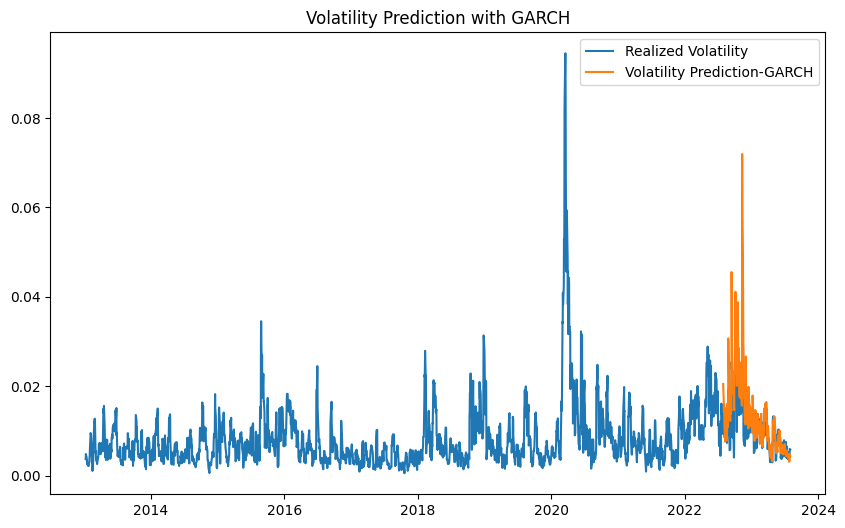

In [41]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100,
        label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

In [42]:
#EGARCH
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(ret, mean='zero', vol='EGARCH', p=p, q=q)\
                .fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch_model(ret, mean='zero', vol='EGARCH',
                    p=best_param[0], q=best_param[1])\
        .fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3357.75
Distribution:                  Normal   AIC:                           6721.51
Method:            Maximum Likelihood   BIC:                           6739.17
                                        No. Observations:                 2661
Date:                Wed, Feb 28 2024   Df Residuals:                     2661
Time:                        10:43:57   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.3336e-04  7.050e-03  3.310e-02      0.974 

In [43]:
rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100,
                        np.sqrt(forecast_egarch.variance\
                        .iloc[-len(split_date):] / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 0.1042


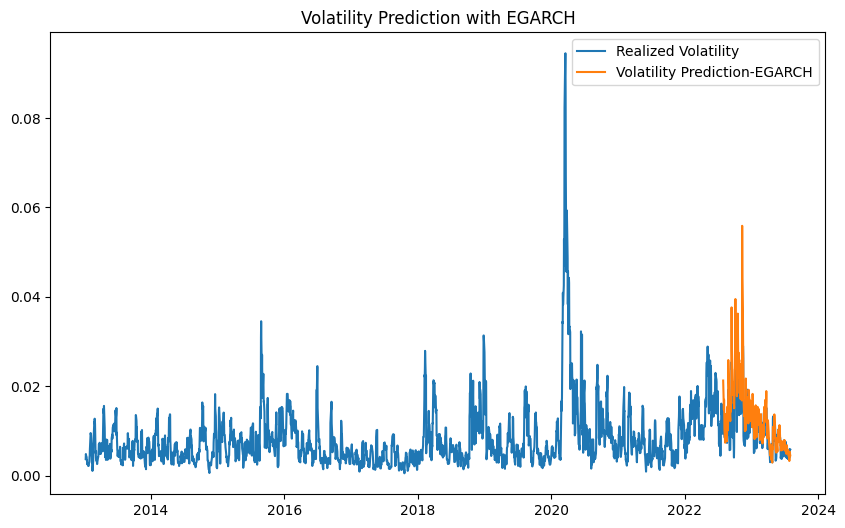

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100,
        label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

In [45]:
#SVM

# Our goal is to use SVM at time t to predict whether a given stock’s price is higher
# or lower on day t +m


from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [46]:
realized_vol = ret.rolling(5).std() #Computing realized volatility and assigning a new variable to it named realized_vol
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [47]:
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']


In [48]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [49]:

realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

#Creating new variables for each SVR kernel
svr_poly = SVR(kernel='poly', degree=2) 
svr_lin = SVR(kernel='linear') 
svr_rbf = SVR(kernel='rbf') 

In [50]:
#SVR-GARCH application with linear kernel
para_grid = {'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()} #Identifying the hyperparameter space for tuning

clf = RandomizedSearchCV(svr_lin, para_grid) #Applying hyperparameter tuning with RandomizedSearchCV

clf.fit(X.iloc[:-n].values,
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,)) #Fitting SVR-GARCH with linear kernel to data

predict_svr_lin = clf.predict(X.iloc[-n:]) #Predicting the volatilities based on the last 252 observations and storing them in the predict_svr_lin

In [51]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [52]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                    predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
    .format(rmse_svr))


The RMSE value of SVR with Linear Kernel is 0.000774


In [53]:
realized_vol.index = ret.iloc[4:].index

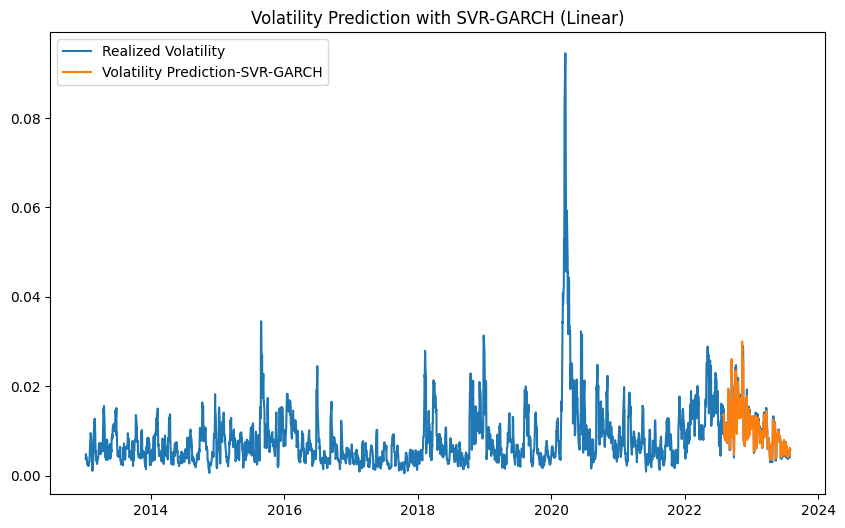

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

In [55]:
# SVR-GARCH application using the RBF kernel
para_grid ={'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values,
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

In [56]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [57]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                        predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'
    .format(rmse_svr_rbf))


The RMSE value of SVR with RBF Kernel is  0.000924


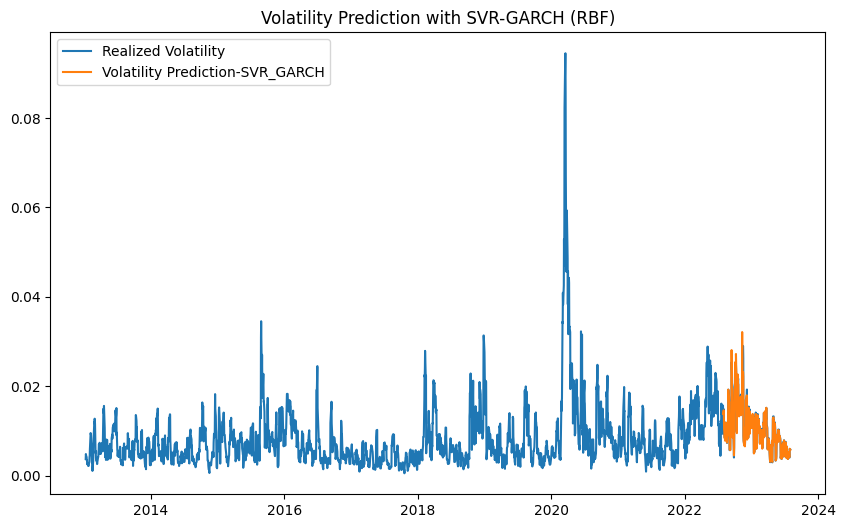

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

In [59]:
#SVR-GARCH with the polynomial kernel
para_grid = {'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_poly, para_grid)
clf.fit(X.iloc[:-n].values,
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_poly = clf.predict(X.iloc[-n:])

In [60]:
predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = ret.iloc[-n:].index

In [61]:
rmse_svr_poly = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                            predict_svr_poly / 100))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'\
    .format(rmse_svr_poly))


The RMSE value of SVR with Polynomial Kernel is 0.002517


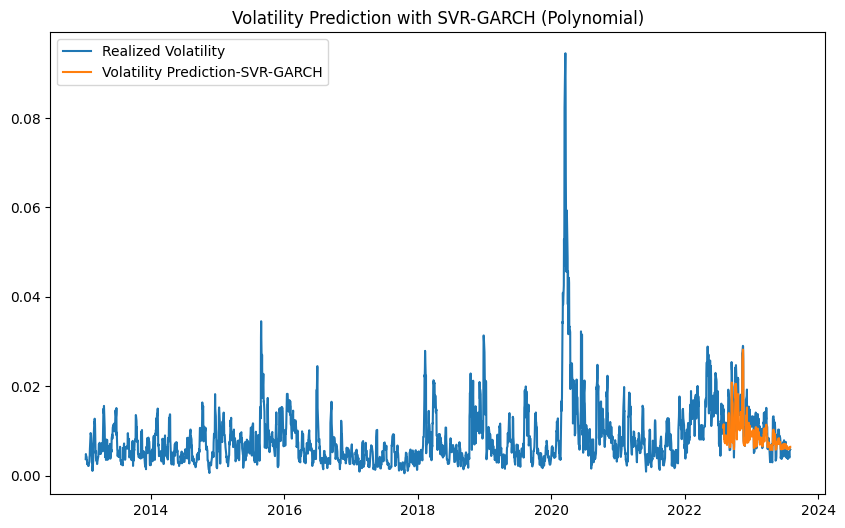

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Polynomial)',
        fontsize=12)
plt.legend()
plt.show()